In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../predictions.csv')

In [3]:
from sklearn.preprocessing import MinMaxScaler

df['Normalized Observed'] = MinMaxScaler().fit_transform(df[['Observed log(TX/Txref)']])

In [4]:
def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = []
    for nucleotide in sequence:
         encoding += [mapping[nucleotide]]
    return encoding


X = df[['UP', 'h35', 'spacs', 'h10', 'disc', 'ITR']]
y = df['Normalized Observed']

upstream_padding = {}
for col in X.columns:
    max_len = X[col].apply(len).max()
    upstream_padding[col] = np.array([padded_one_hot_encode('0' * (max_len - len(seq)) + seq) for seq in X[col]])

X = np.concatenate([upstream_padding[col] for col in X.columns], axis=1)

In [5]:
# Create arrays for each sequence
ones = np.full(22, 1.0)
eights = np.full(6, 0.9)
sixes = np.full(19, 1.0)
fours = np.full(6, 0.9)
twos = np.full(8, 1.0)
zeros = np.full(21, 0.9)

# Concatenate all arrays into one
element_labels = np.concatenate([ones, eights, sixes, fours, twos, zeros])


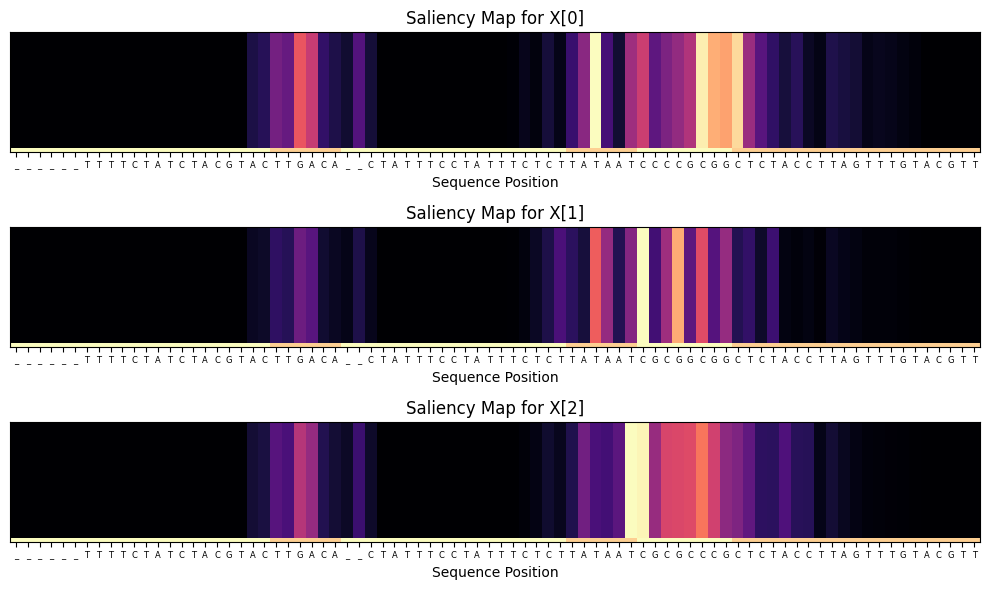

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load your CNN model
model = tf.keras.models.load_model('CNN_kernal_4.keras')

# Function to generate saliency map for DNA sequence
def generate_saliency_map(model, input_sequence, target_class_index):
    input_tensor = tf.convert_to_tensor(input_sequence[np.newaxis, ...], dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        predictions = model(input_tensor)
        loss = predictions[0, target_class_index]
        
    gradients = tape.gradient(loss, input_tensor)
    
    # Normalize gradients
    gradients = tf.norm(gradients, axis=-1)
    gradients = gradients / tf.reduce_max(gradients)
    
    return gradients.numpy()

# Define target class index
target_class_index = 0

# Generate saliency maps for both sequences
saliency_1 = generate_saliency_map(model, X[1], target_class_index)

# Define mapping and labels
mapping = {(1,0,0,0): 'A', (0,1,0,0): 'C', (0,0,1,0): 'G', (0,0,0,1): 'T', (0,0,0,0): '_'}

subplots = 3
fig, axes = plt.subplots(subplots, 1, figsize=(10, 6))

for i in range(subplots):
    axes[i].imshow(np.vstack([np.vstack([generate_saliency_map(model, X[i], target_class_index) for _ in range(30)]), element_labels]),
                   cmap='magma',
                   aspect='auto')
    axes[i].set_xlabel('Sequence Position')
    axes[i].set_xticks(np.arange(len(X[i])))
    axes[i].set_xticklabels([mapping[tuple(each)] for each in X[i]], fontsize=6)
    axes[i].set_yticks([])
    axes[i].set_title(f'Saliency Map for X[{i}]')

plt.tight_layout()
plt.show()


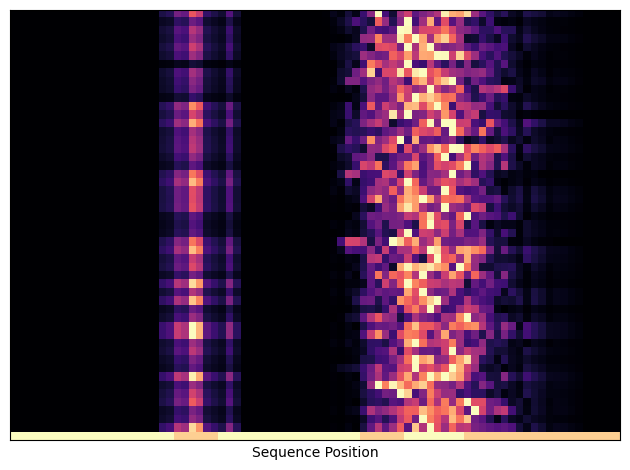

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load your CNN model
model = tf.keras.models.load_model('CNN_kernal_4.keras')

# Function to generate saliency map for DNA sequence
def generate_saliency_map(model, input_sequence, target_class_index):
    input_tensor = tf.convert_to_tensor(input_sequence[np.newaxis, ...], dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        predictions = model(input_tensor)
        loss = predictions[0, target_class_index]
        
    gradients = tape.gradient(loss, input_tensor)
    
    # Normalize gradients
    gradients = tf.norm(gradients, axis=-1)
    gradients = gradients / tf.reduce_max(gradients)
    
    return gradients.numpy()


target_class_index = 0
plt.imshow(np.vstack([np.vstack([generate_saliency_map(model, X[i], target_class_index) for i in range(50)]), element_labels]),
           cmap='magma',
           aspect='auto')
plt.xlabel('Sequence Position')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()
